In [406]:
from dateutil.parser import parse
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric




data_path_write = 'C:\\Users\\Henry\\Documents\\405-DataScience\\G_Suite_Metrics\\data\\Gmail\\Time_predictions_on_5_attributes\\'
data_path_write2 = 'C:\\Users\\Henry\\Documents\\405-DataScience\\G_Suite_Metrics\\data\\Gmail\\All_pre-prediction_attributes\\'
#fa = pd.read_csv(data_path)
#entire_dataset = pd.read_csv(data_path2)

Function to pick which data to perform time prediction analysis on. 1 is for emails received, 2 is all gmail data, 3 is the five attributes

In [122]:
def pick_your_poison(number):
    if (number == 1):
        df = pd.read_csv("C:\\Users\\Henry\\Documents\\405-DataScience\\G_Suite_Metrics\\data\\Gmail\\Data\\cbt.csv")
        print("You picked cbt.csv")
        return df
    if (number == 2):
        df = pd.read_csv("C:\\Users\\Henry\\Documents\\405-DataScience\\G_Suite_Metrics\\data\\Gmail\\Data\\gmail_df.csv")
        print("You picked overall data")
        return df
    if (number == 3):
        df = pd.read_csv("C:\\Users\\Henry\\Documents\\405-DataScience\\G_Suite_Metrics\\data\\Gmail\\Data\\gmail_df.csv")
        df = df[['time','emails_received','emails_sent','inbound_rejected_emails','inbound_spam_emails','inbound_non_spam_emails']]
        print("The five attributes")
        return df
    if(number == 4):
        df = pd.read_csv("C:\\Users\\Henry\\Documents\\405-DataScience\\G_Suite_Metrics\\data\\Gmail\\Time_predictions_on_5_attributes\\" + metric_name + ".csv")
        return df
    else:
        df = []
        print("No dataset for you")
    return df
    

Function to pass column time as a date time object and set time as an index. It is important for plotting

In [5]:
def time_set(df):
    import datetime as dt
    df[df.columns[0]] = pd.to_datetime(df[df.columns[0]],utc = True)
    df[df.columns[0]]= df.time.dt.date
    df.set_index(df.columns[0])
    return df

Function to plot the predicted values and the original data

In [335]:
def plot(df,df0, time):
    #Plt.plot requires the index to be a time series, if the df index is not a time series then this if condition will set it
    if(time == True):
        df1 = df.copy()
        df2 = df0.copy()
        df1 = time_set(df1)
        df2 = time_set(df2)
    elif(time == False):
        df1 = df.copy()
        df2 = df0.copy()
    for x in range(len(df1.columns)):
        plt.figure(figsize=(22, 10))
        plt.plot(df1.index, df1[df1.columns[x]], label=df1.columns[x])
        plt.plot(df2.index, df2[df2.columns[x]], label='Prophet', color='r')
        plt.legend(loc='best', fontsize='xx-large')
        plt.show()

Function to do time prediction

In [23]:
def timeprediction123(df,csvfilename):
    p = Prophet(weekly_seasonality=True, seasonality_mode='multiplicative', changepoint_prior_scale=0.7)
    #changepoint_prior changes the fit of the prediction
    df = df.rename(columns={df.columns[0]: "ds", df.columns[1]: "y"})
    
    df['ds'] = pd.to_datetime(df['ds'], utc=True)
    df['ds']= df.ds.dt.date
    df.index.freq = 'D'
    #get forecast

    p.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
    future = p.make_future_dataframe(periods=365)
    time_pred = p.predict(future)
    df1 = time_pred[['ds','yhat']]
    df_cv = cross_validation(p, initial='370 days', period='180 days', horizon = '365 days')
    
    df_p = performance_metrics(df_cv)
    print("Performance head for " + csvfilename)
    print(df_p.head())
    print("Performance tail for " + csvfilename)
    print(df_p.tail())

    
    df1.to_csv(data_path_write + csvfilename + "_prediction" + ".csv", index = False)
    df2 = time_pred[['yhat']]
    p.plot(time_pred)
    return df1,df2,time_pred

In [8]:
def timepredictionMAPE(df,csvfilename):
    p = Prophet(weekly_seasonality=True, seasonality_mode='multiplicative', changepoint_prior_scale=0.7)
    #changepoint_prior changes the fit of the prediction
    df = df.rename(columns={df.columns[0]: "ds", df.columns[1]: "y"})
    
    df['ds'] = pd.to_datetime(df['ds'], utc=True)
    df['ds']= df.ds.dt.date
    df.index.freq = 'D'
    #get forecast

    p.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
    future = p.make_future_dataframe(periods=365)
    time_pred = p.predict(future)
    df1 = time_pred[['ds','yhat']]
    df_cv = cross_validation(p, initial='370 days', period='180 days', horizon = '365 days')
    try:
        print("MAPE for " + csvfilename + " predictions")
        fig = plot_cross_validation_metric(df_cv, metric='mape')
    except:
        print("MAPE way too low to be graphed, prediction is very good")
    df2 = time_pred[['yhat']]
    return df1,df2,time_pred

Function to send all columns in a dataframe to timeprediction123

In [383]:
def send_prediction(df):
    df_with_all_preds = timeprediction123(df = df[['time', df.columns[1]]], csvfilename = df.columns[1])[0]
    df_with_all_preds = df_with_all_preds.rename(columns= {df_with_all_preds.columns[0] : "time", df_with_all_preds.columns[1] : five_att.columns[1]})
    df1= df.drop(columns= [df.columns[1]])
    
    for x in range(len(df1.columns) - 1):
        h =timeprediction123(df = df1[['time', df1.columns[x+1]]], csvfilename = df1.columns[x+1])[0]
        h =h.rename(columns = {h.columns[0]: "time", h.columns[1] : df1.columns[x+1]})
        df_with_all_preds =  df_with_all_preds.merge(h, on = "time")
    return df_with_all_preds

In [384]:
def send_predictionMAPE(df):
    df_with_all_preds = timepredictionMAPE(df = df[['time', df.columns[1]]], csvfilename = df.columns[1])[0]
    df_with_all_preds = df_with_all_preds.rename(columns= {df_with_all_preds.columns[0] : "time", df_with_all_preds.columns[1] : five_att.columns[1]})
    df1= df.drop(columns= [df.columns[1]])
    
    for x in range(len(df1.columns) - 1):
        h =timepredictionMAPE(df = df1[['time', df1.columns[x+1]]], csvfilename = df1.columns[x+1])[0]
        h =h.rename(columns = {h.columns[0]: "time", h.columns[1] : df1.columns[x+1]})
        df_with_all_preds =  df_with_all_preds.merge(h, on = "time")
    return df_with_all_preds

This function basically reindexes the original dataset and fills 0s with predicted values. If it finds any negative values then it caps it at 0

In [355]:
def fill_zero(df1, pred):
    df1 = time_set(df1)
    pred = time_set(pred)
    pred = pred.apply(np.ceil)
    
    idx = pd.date_range('03-23-2015', '08-17-2019')
    df1 = df1.reindex(idx, fill_value = 0)
    #This for loop changes all negative values to 0 in the prediction
    for x in range(len(pred.columns)):
        for j in range(len(pred)):
            if(pred[pred.columns[x]].iloc[j] < 0 ):
                pred[pred.columns[x]].iloc[j] = 0
    #Fills 0s in the original dataset with predicted values
    for x in range(len(df1.columns)):
        for j in range(len(df1)):
            if(df1[df1.columns[x]].iloc[j] == 0):
                df1[df1.columns[x]].iloc[j] = pred[pred.columns[x]].iloc[j]
    
        
    return df1,pred


    

Time prediction actually begins here

In [400]:
five_att = pick_your_poison(3)

The five attributes


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Skipping MAPE because y close to 0


Performance head for emails_received
  horizon           mse           rmse           mae  coverage
0 37 days  1.063875e+10  103144.327645  72638.334515  0.647472
1 38 days  1.064978e+10  103197.775337  72966.972450  0.642697
2 39 days  1.071549e+10  103515.641301  73504.380186  0.634831
3 40 days  1.086250e+10  104223.317168  74317.187624  0.628090
4 41 days  1.149331e+10  107206.863179  75915.532634  0.622472
Performance tail for emails_received
     horizon           mse           rmse           mae  coverage
324 361 days  9.624030e+09   98102.141934  78303.361675       1.0
325 362 days  9.767624e+09   98831.291454  79093.797753       1.0
326 363 days  1.011600e+10  100578.336621  81025.210681       1.0
327 364 days  1.042279e+10  102092.043915  82491.222367       1.0
328 365 days  1.067501e+10  103319.941951  83489.210075       1.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Skipping MAPE because y close to 0


Performance head for emails_sent
  horizon           mse          rmse          mae  coverage
0 37 days  1.135828e+08  10657.523394  7663.789091  0.675562
1 38 days  1.137079e+08  10663.392418  7668.378906  0.676404
2 39 days  1.145202e+08  10701.413367  7727.414723  0.668539
3 40 days  1.169416e+08  10813.951763  7815.075722  0.659551
4 41 days  1.252543e+08  11191.705119  8023.918215  0.659551
Performance tail for emails_sent
     horizon           mse         rmse          mae  coverage
324 361 days  6.092425e+07  7805.398956  5443.234480  0.994382
325 362 days  6.030276e+07  7765.485228  5394.485479  0.994382
326 363 days  6.220857e+07  7887.240973  5447.609068  0.994382
327 364 days  6.176887e+07  7859.317210  5463.522030  0.994382
328 365 days  6.185551e+07  7864.827426  5502.099955  0.994382


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00


Performance head for inbound_rejected_emails
  horizon           mse          rmse          mae      mape  coverage
0 37 days  1.434504e+08  11977.076514  6567.533752  0.384347  0.876404
1 38 days  1.549138e+08  12446.438950  6781.964760  0.392789  0.873034
2 39 days  1.642346e+08  12815.406002  6960.662393  0.401722  0.873034
3 40 days  2.432327e+08  15595.919538  7643.244993  0.413607  0.867416
4 41 days  2.663361e+08  16319.806176  8040.934283  0.434724  0.859551
Performance tail for inbound_rejected_emails
     horizon           mse          rmse           mae      mape  coverage
324 361 days  6.152078e+08  24803.382980  19549.468634  2.964250       1.0
325 362 days  6.180281e+08  24860.170036  19611.683346  2.982426       1.0
326 363 days  6.236441e+08  24972.867623  19724.410723  3.013531       1.0
327 364 days  6.250105e+08  25000.209251  19748.989436  3.031757       1.0
328 365 days  6.099041e+08  24696.235858  19598.205515  3.057537       1.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00


Performance head for inbound_spam_emails
  horizon           mse          rmse          mae      mape  coverage
0 37 days  9.256396e+07   9621.016827  7318.018081  0.213389  0.754213
1 38 days  9.474125e+07   9733.511537  7399.084644  0.217460  0.755056
2 39 days  1.005092e+08  10025.427615  7610.438961  0.224520  0.747191
3 40 days  1.070698e+08  10347.452886  7889.226829  0.232287  0.738202
4 41 days  1.109977e+08  10535.542723  8040.367691  0.237438  0.732584
Performance tail for inbound_spam_emails
     horizon           mse          rmse           mae      mape  coverage
324 361 days  7.682302e+08  27716.965777  19693.303806  0.834339       1.0
325 362 days  7.672593e+08  27699.446068  19755.599260  0.831326       1.0
326 363 days  7.566741e+08  27507.709364  19719.576734  0.834576       1.0
327 364 days  7.486678e+08  27361.795289  19698.846304  0.840132       1.0
328 365 days  7.530992e+08  27442.653688  19777.062626  0.845944       1.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00


Performance head for inbound_non_spam_emails
  horizon           mse          rmse           mae      mape  coverage
0 37 days  1.317894e+09  36302.816185  28385.771155  0.158986  0.653090
1 38 days  1.381761e+09  37172.042002  29154.815395  0.162070  0.637079
2 39 days  1.424802e+09  37746.544387  29391.705309  0.162627  0.633708
3 40 days  1.507902e+09  38831.710463  30233.590498  0.169038  0.622472
4 41 days  1.553794e+09  39418.197358  30760.114585  0.173529  0.614607
Performance tail for inbound_non_spam_emails
     horizon           mse          rmse           mae      mape  coverage
324 361 days  5.928211e+09  76994.876461  67311.089280  0.441013  0.874157
325 362 days  5.995160e+09  77428.419534  67631.109014  0.439034  0.874157
326 363 days  6.182256e+09  78627.322392  68532.111730  0.437984  0.870787
327 364 days  6.347465e+09  79670.978264  69365.551447  0.438490  0.865169
328 365 days  6.412901e+09  80080.592092  69882.876172  0.440116  0.862921


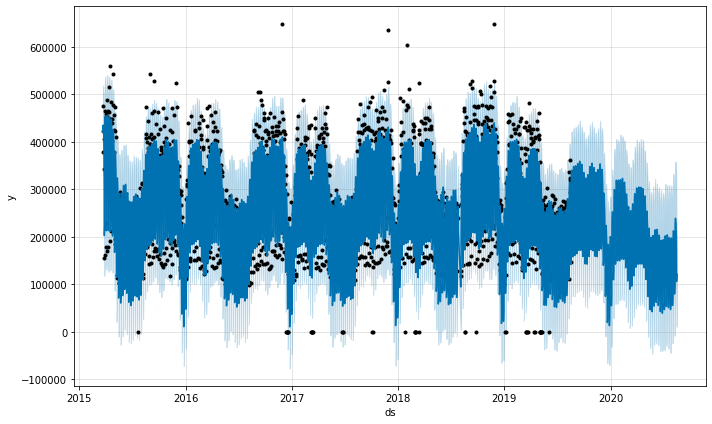

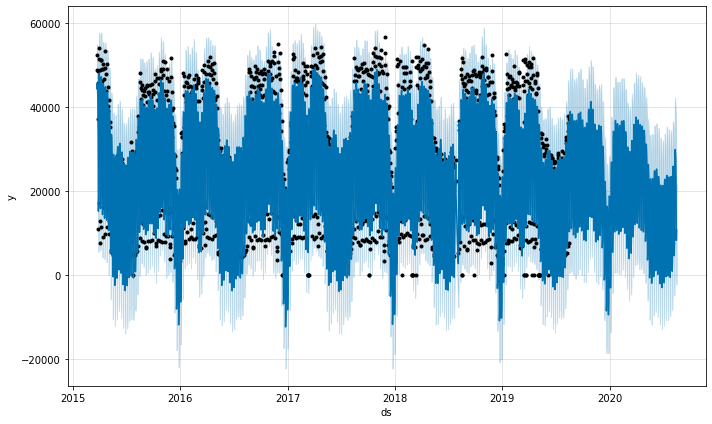

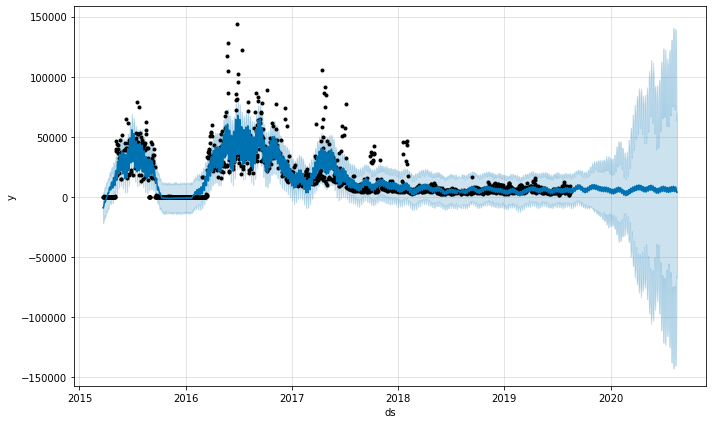

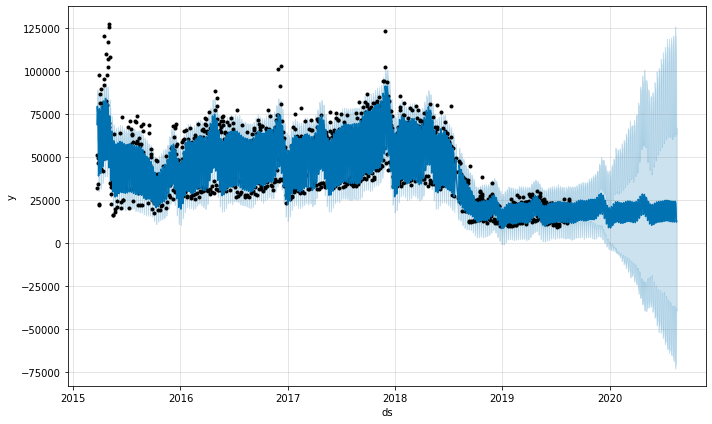

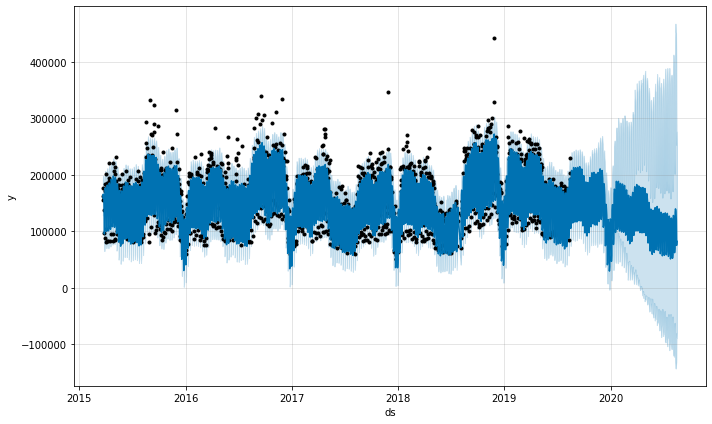

In [401]:
prediction = send_prediction(five_att)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE for emails_received predictions
MAPE way too low to be graphed, prediction is very good


INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE for emails_sent predictions
MAPE way too low to be graphed, prediction is very good


INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE for inbound_rejected_emails predictions


INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE for inbound_spam_emails predictions


INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00


MAPE for inbound_non_spam_emails predictions


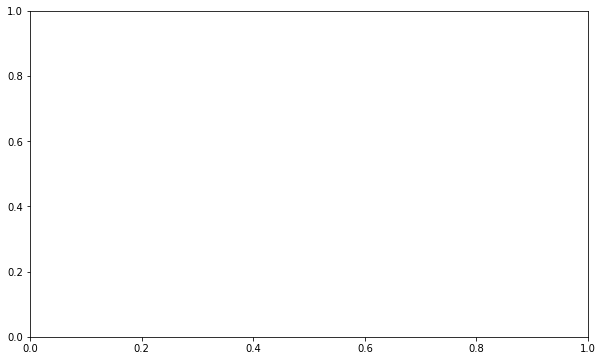

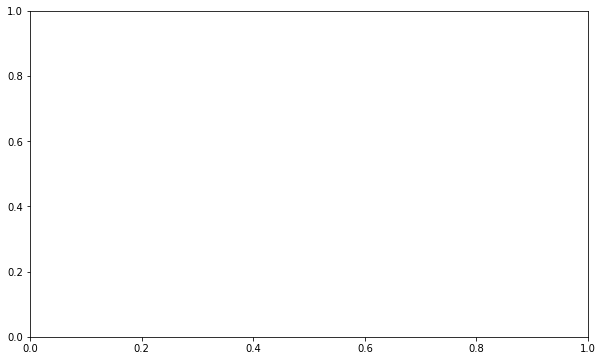

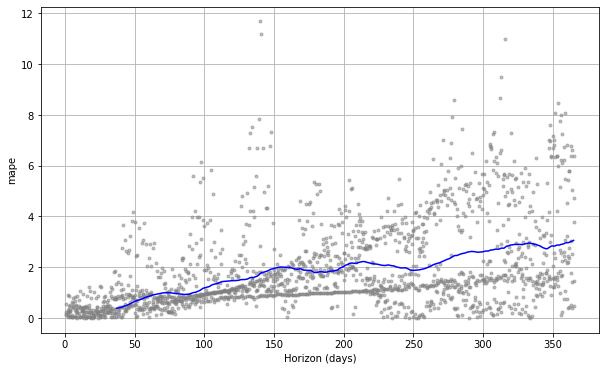

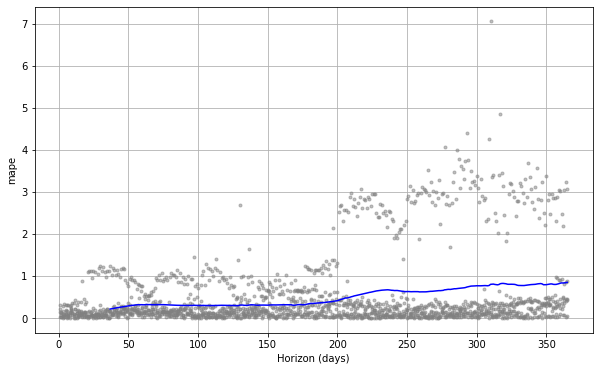

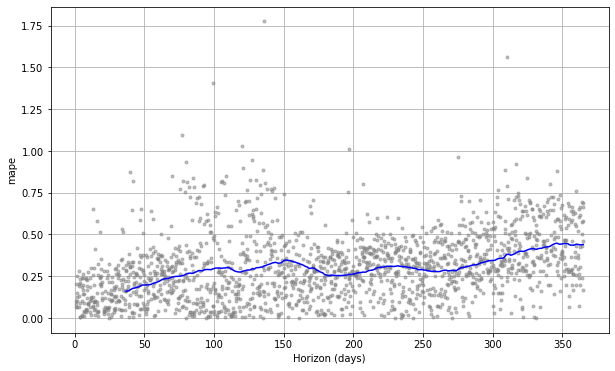

In [13]:
prediction1 = send_predictionMAPE(five_att)

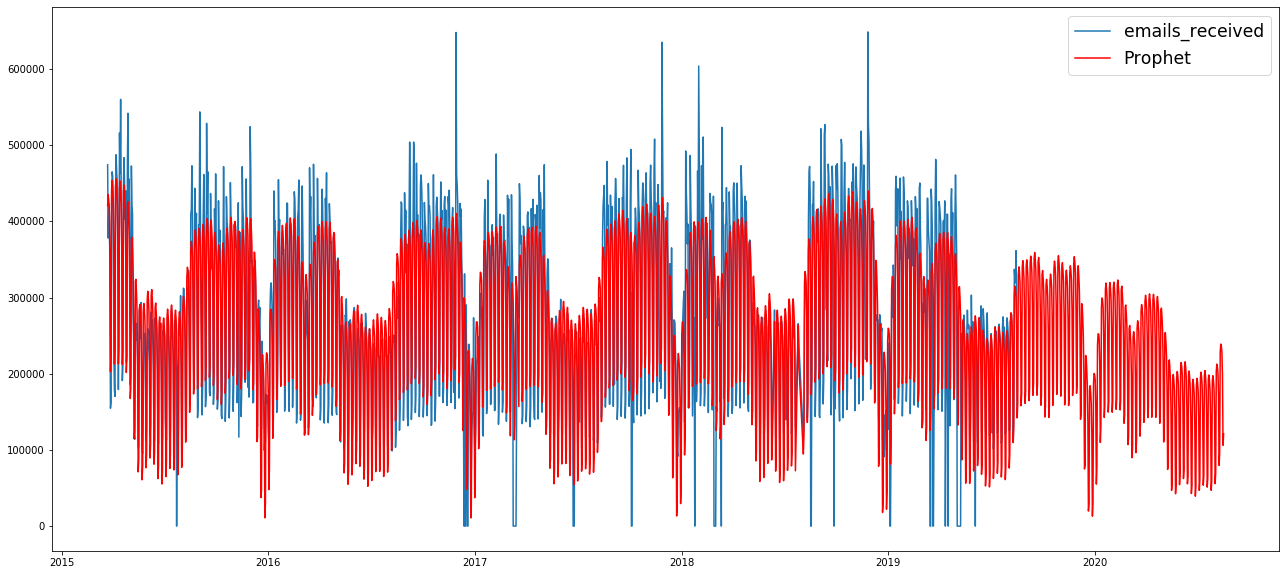

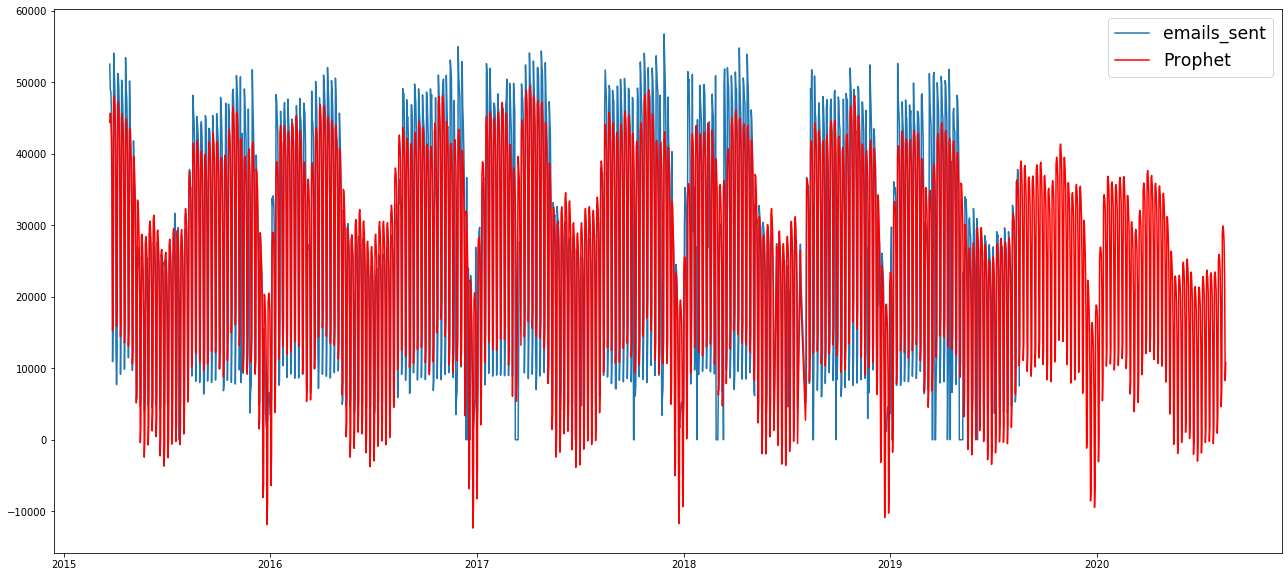

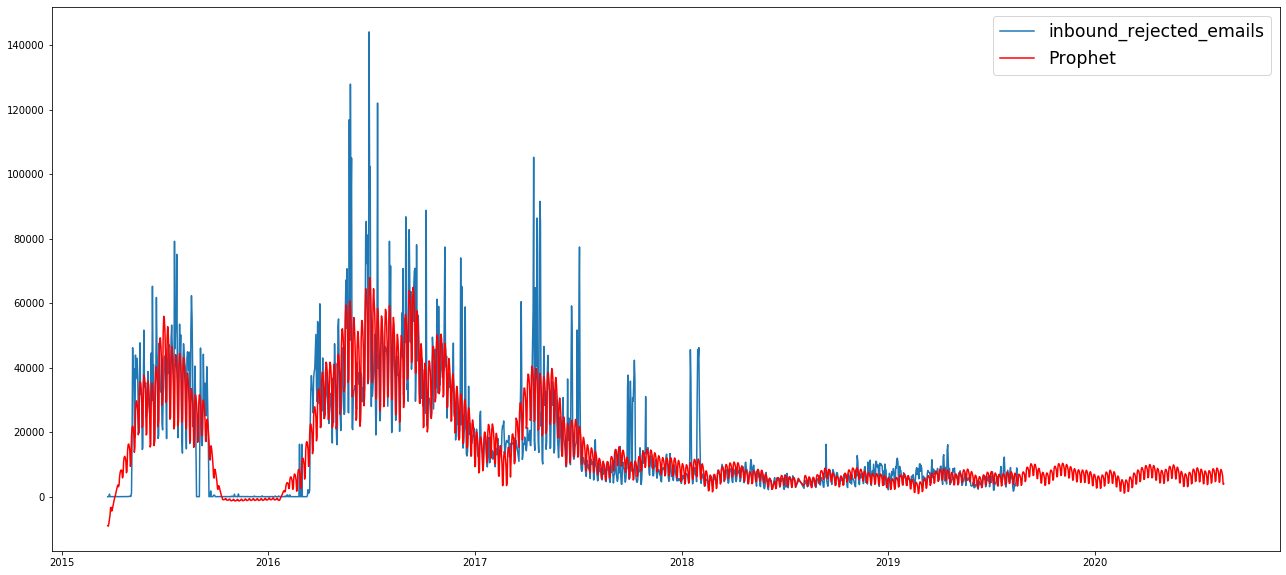

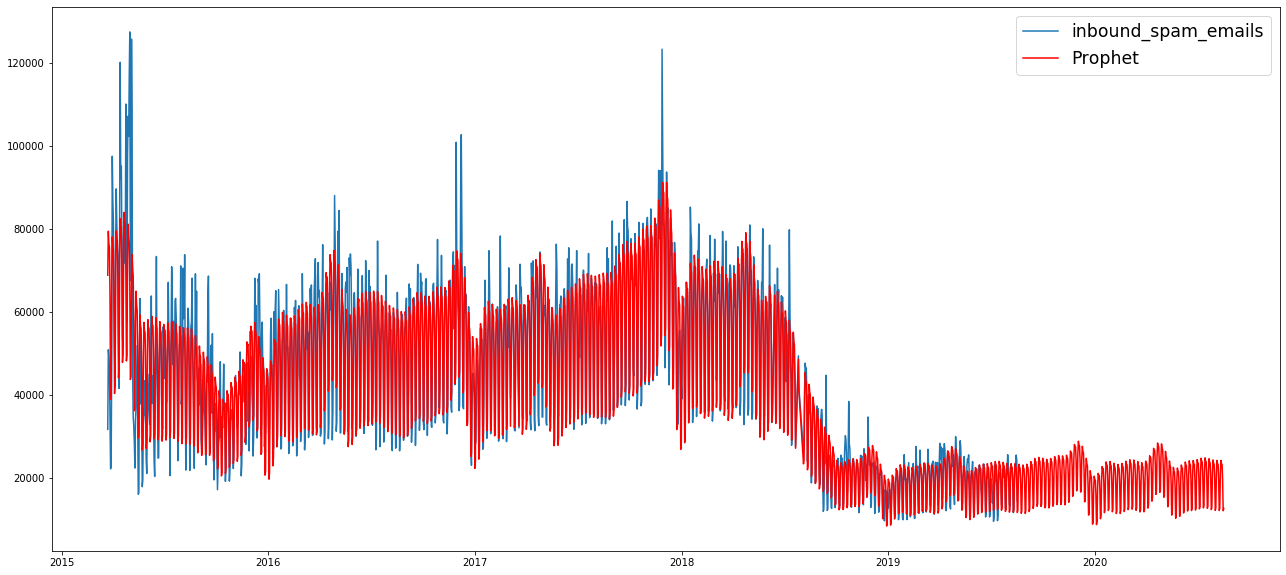

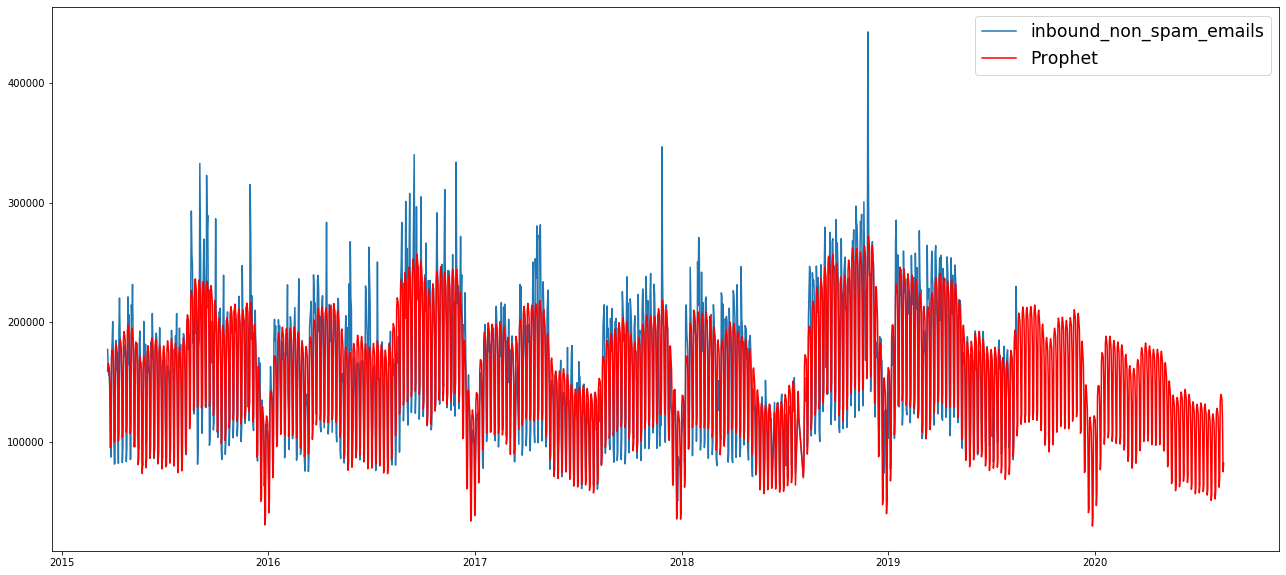

In [14]:
plot(five_att,prediction,True)

In [67]:
prediction.head()

time  emails_received   emails_sent  inbound_rejected_emails  \
0 2015-03-23    420751.178741  44416.560004             -9011.702713   
1 2015-03-24    435382.645064  45682.977138             -9124.979106   
2 2015-03-25    427943.748731  44706.242837             -8281.172344   
3 2015-03-26    411576.525877  42390.299846             -7083.514472   
4 2015-03-27    356726.773040  35314.818709             -5780.726718   

   inbound_spam_emails  inbound_non_spam_emails  
0         68832.073538            159325.646064  
1         79416.249246            165692.286979  
2         76444.853147            164233.264236  
3         75545.000854            161522.825442  
4         63505.938412            143495.244656

Filling 0s in the dataset for the 5 Attributes

In [414]:
prediction1 = prediction.copy()

In [413]:
five_att = pick_your_poison(3)
#five_att = time_set(five_att)

The five attributes


In [415]:
cbt, cbt2 = fill_zero(five_att,prediction1)

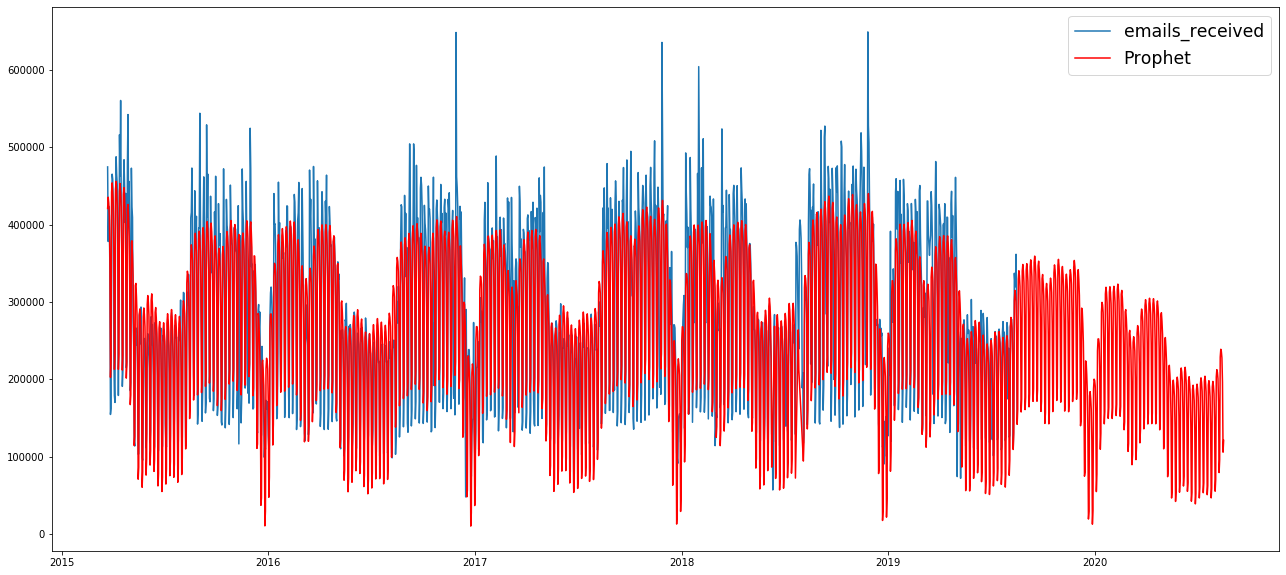

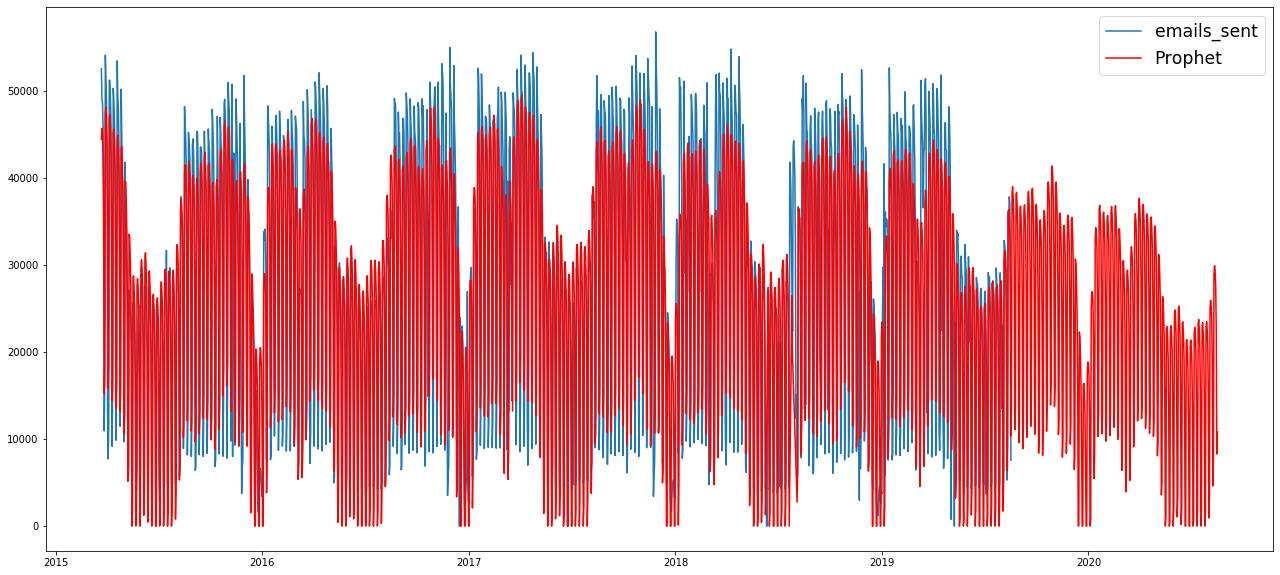

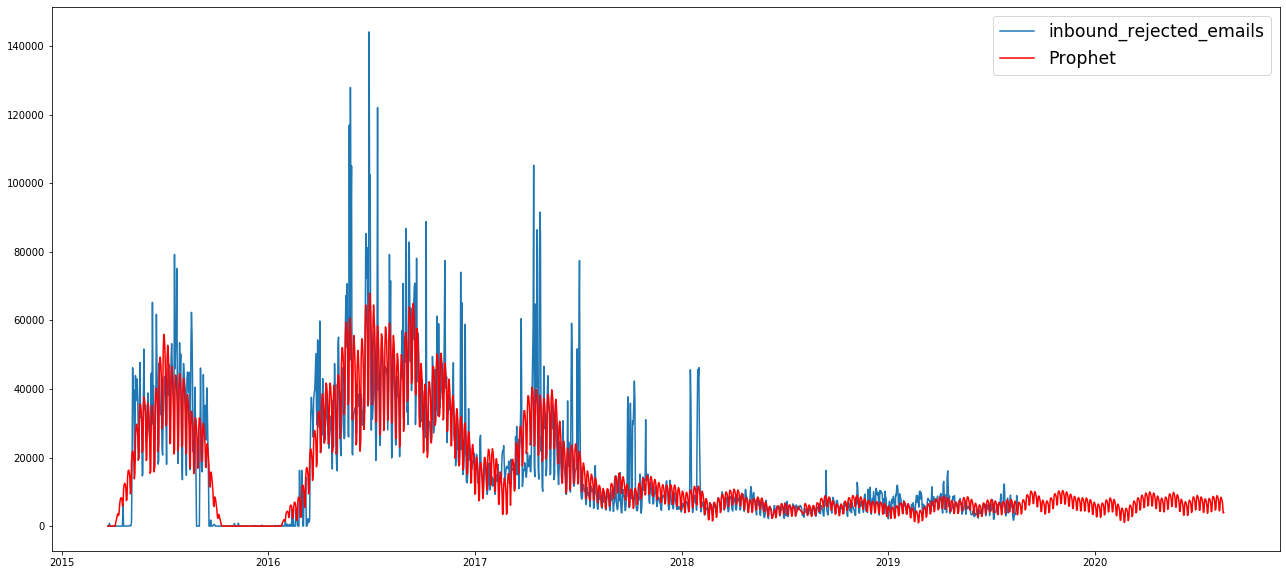

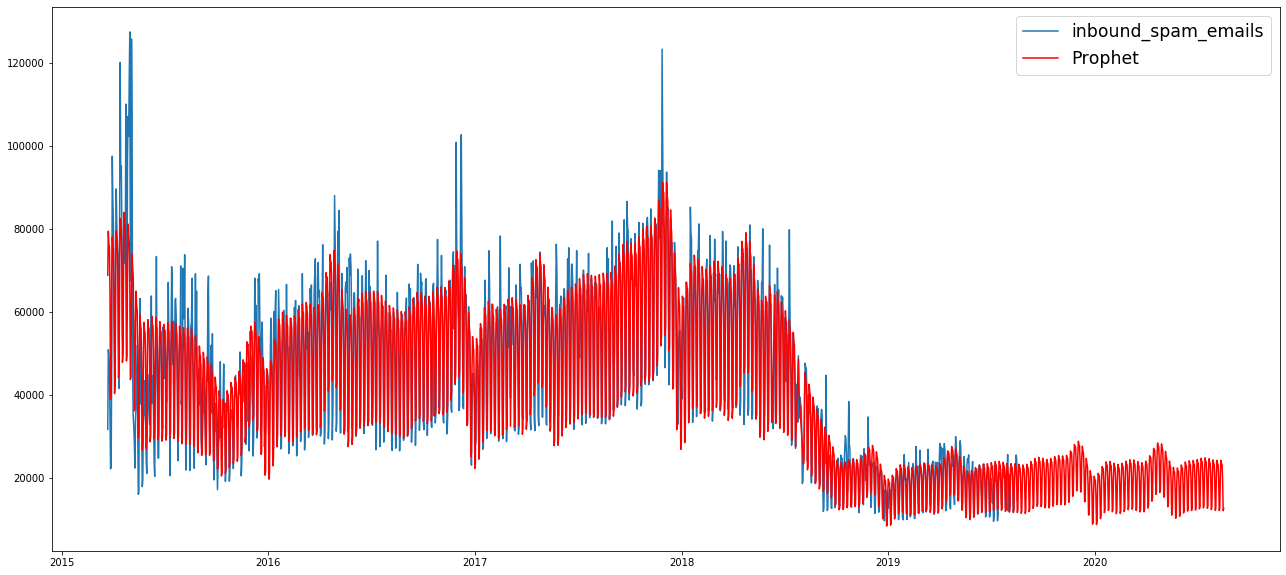

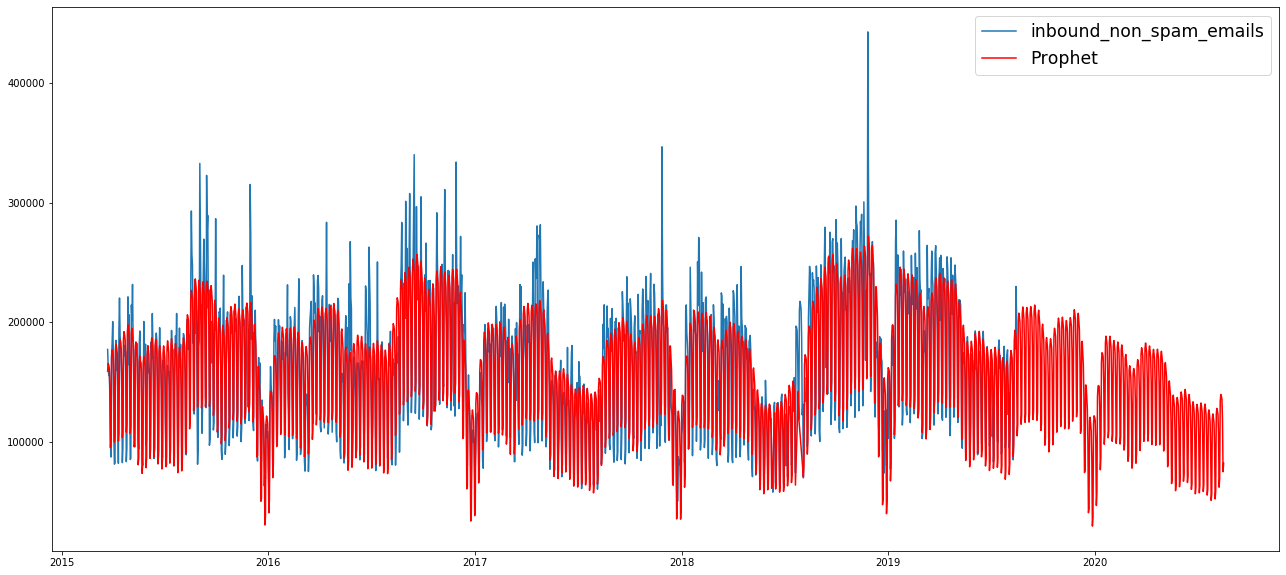

In [417]:
plot(cbt,cbt2,False)

Prediction for other attributes

In [402]:
other = pick_your_poison(2)

You picked overall data


In [386]:
other.head()

time  1day_active_users  1day_imap_users  1day_pop_users  1day_webmail_users  30day_active_users  30day_imap_users  30day_pop_users  30day_webmail_users  7day_active_users  ...  inbound_non_spam_emails  inbound_rejected_emails  inbound_rerouted_emails  inbound_spam_emails  inbound_unencrypted_emails  outbound_delivered_emails  outbound_encrypted_emails  outbound_rejected_emails  outbound_rerouted_emails  outbound_unencrypted_emails
0  2015-03-23 00:00:00-04:00            19687.0          10463.0           214.0             12300.0             23980.0           12339.0            265.0              21780.0            22329.0  ...                 177446.0                      2.0                   7064.0              31718.0                    131902.0                        0.0                    26144.0                     667.0                   26072.0                         22.0
1  2015-03-24 00:00:00-04:00            19437.0          10510.0           214.0             12247.0             24025.0           12336.0            264.0              21834.0            22364.0  ...                 163005.0                      6.0                   6143.0              50873.0                    128023.0                        0.0                    23205.0                    1330.0                   23136.0                         15.0
2  2015-03-25 00:00:00-04:00            19520.0          10453.0           212.0             12158.0             24045.0           12357.0            262.0              21862.0            22383.0  ...                 155603.0                      6.0                   6610.0              49373.0                    130719.0                        0.0                    23037.0                     847.0                   22959.0                        229.0
3  2015-03-26 00:00:00-04:00            19335.0          10496.0           213.0             11713.0             24074.0           12365.0            263.0              21897.0            22370.0  ...                 158907.0                    790.0                   7267.0              46494.0                    120764.0                        0.0                    22764.0                     863.0                   22672.0                         33.0
4  2015-03-27 00:00:00-04:00            18768.0          10419.0           204.0             10102.0             24079.0           12340.0            262.0              21890.0            22395.0  ...                 137505.0                     13.0                   5983.0              34066.0                    104999.0                        0.0                    18333.0                     487.0                   18242.0                          7.0

[5 rows x 28 columns]

In [403]:
other = other[['time','1day_active_users','emails_exchanged','inbound_delivered_emails','outbound_rejected_emails']]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Skipping MAPE because y close to 0


Performance head for 1day_active_users
  horizon           mse         rmse          mae  coverage
0 37 days  1.884483e+07  4341.062962  2267.746092  0.838483
1 38 days  1.779271e+07  4218.140902  2211.695514  0.842697
2 39 days  1.783630e+07  4223.304962  2217.762001  0.837079
3 40 days  1.788058e+07  4228.544027  2223.576149  0.831461
4 41 days  2.006351e+07  4479.231134  2320.712313  0.825843
Performance tail for 1day_active_users
     horizon           mse         rmse          mae  coverage
324 361 days  1.693937e+07  4115.746512  3088.087389  0.913483
325 362 days  1.696657e+07  4119.049244  3087.207552  0.919101
326 363 days  1.712143e+07  4137.805175  3107.866809  0.924719
327 364 days  1.738034e+07  4168.973959  3132.036202  0.924719
328 365 days  1.727661e+07  4156.514564  3113.863307  0.930337


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Skipping MAPE because y close to 0


Performance head for emails_exchanged
  horizon           mse           rmse           mae  coverage
0 37 days  1.291337e+10  113637.000291  81000.896227  0.630618
1 38 days  1.293444e+10  113729.675598  81354.422058  0.620225
2 39 days  1.301381e+10  114078.103945  81945.224514  0.612360
3 40 days  1.320130e+10  114896.921381  82871.922750  0.605618
4 41 days  1.399397e+10  118296.100454  84748.366303  0.597753
Performance tail for emails_exchanged
     horizon           mse           rmse           mae  coverage
324 361 days  1.065811e+10  103238.129323  79949.255738       1.0
325 362 days  1.079890e+10  103917.756203  80729.285108       1.0
326 363 days  1.127481e+10  106182.922992  82981.896803       1.0
327 364 days  1.169961e+10  108164.736280  84717.732247       1.0
328 365 days  1.205683e+10  109803.616163  85959.198352       1.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for inbound_delivered_emails
  horizon           mse          rmse           mae      mape  coverage
0 37 days  1.235373e+09  35147.873236  26428.395759  0.120757  0.653090
1 38 days  1.290142e+09  35918.540606  27224.377400  0.123726  0.642697
2 39 days  1.328259e+09  36445.287611  27668.324054  0.125319  0.633708
3 40 days  1.382539e+09  37182.508981  28277.670305  0.129107  0.625843
4 41 days  1.411832e+09  37574.349763  28747.579752  0.131859  0.611236
Performance tail for inbound_delivered_emails
     horizon           mse          rmse           mae      mape  coverage
324 361 days  5.236696e+09  72365.016988  63763.105610  0.335609       1.0
325 362 days  5.303981e+09  72828.436660  64306.021806  0.334834       1.0
326 363 days  5.436165e+09  73730.354676  65406.377328  0.337221       1.0
327 364 days  5.520869e+09  74302.550087  66122.048787  0.339061       1.0
328 365 days  5.546191e+09  74472.753682  66458.184582  0.339887       1.0


INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00


Performance head for outbound_rejected_emails
  horizon          mse       rmse        mae      mape  coverage
0 37 days  2836.691417  53.260599  40.356168  0.363118  0.994382
1 38 days  2889.084562  53.750205  40.734618  0.364362  0.994382
2 39 days  3022.035011  54.973039  41.498797  0.372478  0.994382
3 40 days  3180.262616  56.393817  42.384711  0.380379  0.994382
4 41 days  3221.507433  56.758325  42.677419  0.381749  0.994382
Performance tail for outbound_rejected_emails
     horizon          mse       rmse        mae      mape  coverage
324 361 days  8323.072611  91.230875  75.380491  0.515400       1.0
325 362 days  8139.044828  90.216655  74.312167  0.502642       1.0
326 363 days  8017.012016  89.537769  73.724823  0.490806       1.0
327 364 days  7842.324264  88.556898  73.141723  0.486923       1.0
328 365 days  7788.146101  88.250474  73.324807  0.488936       1.0


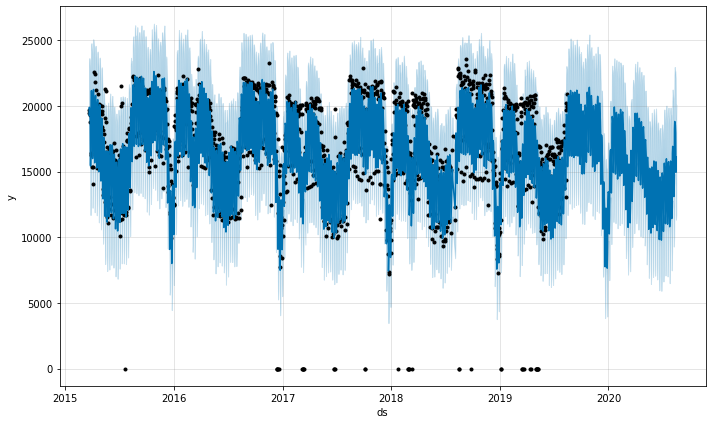

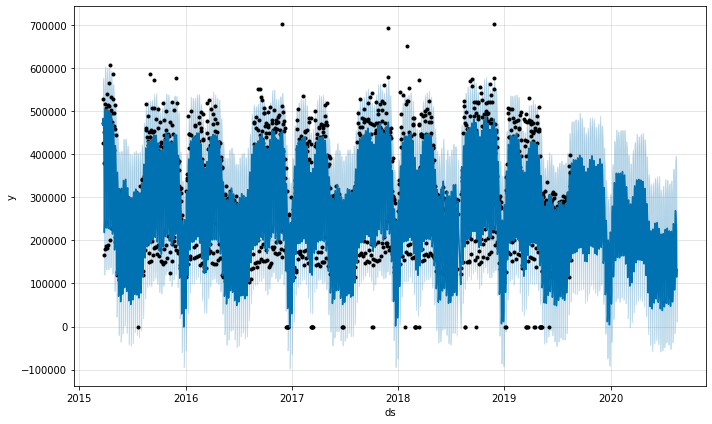

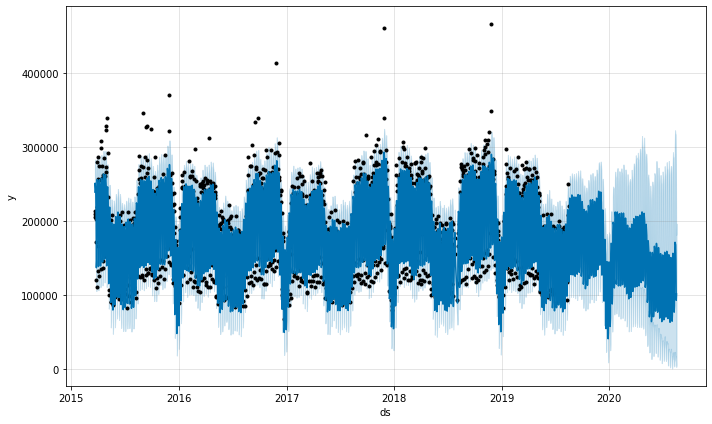

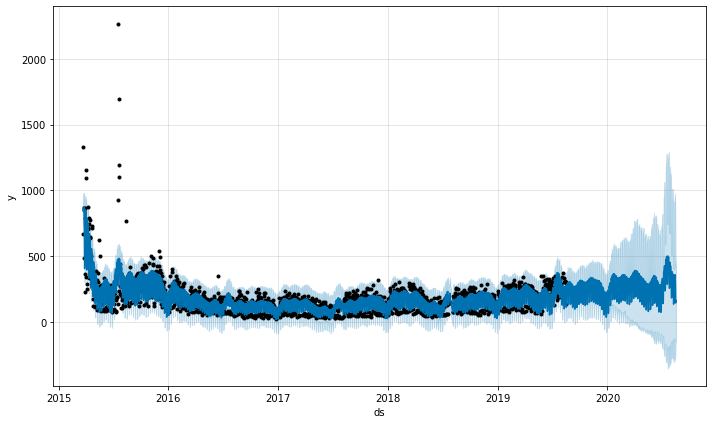

In [404]:
other_prediction = send_prediction(other)

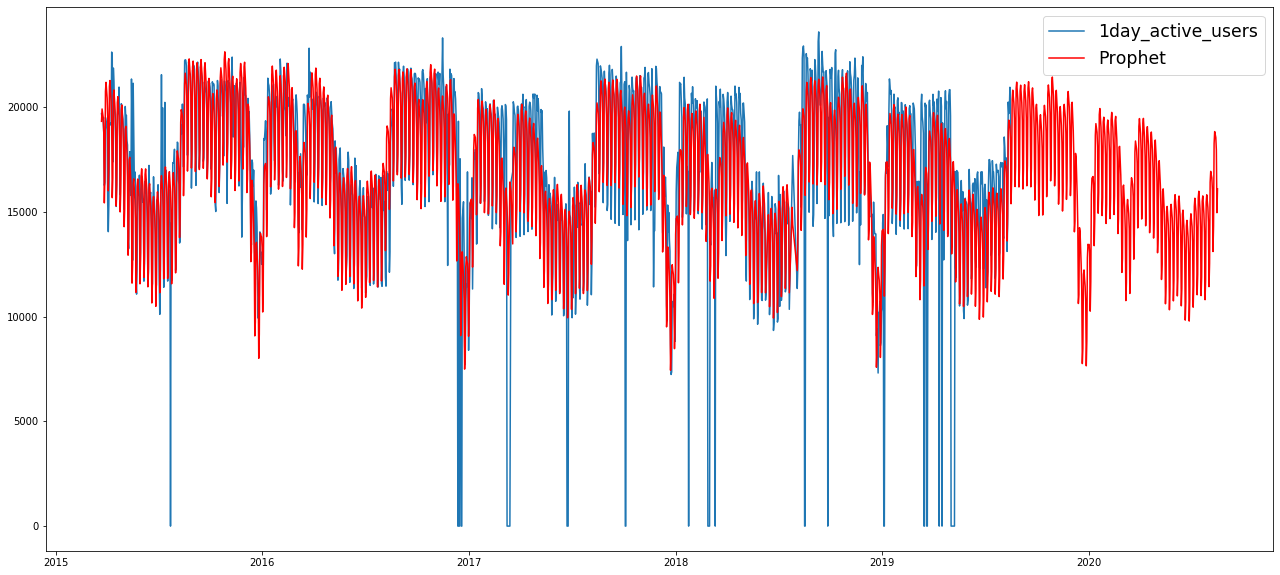

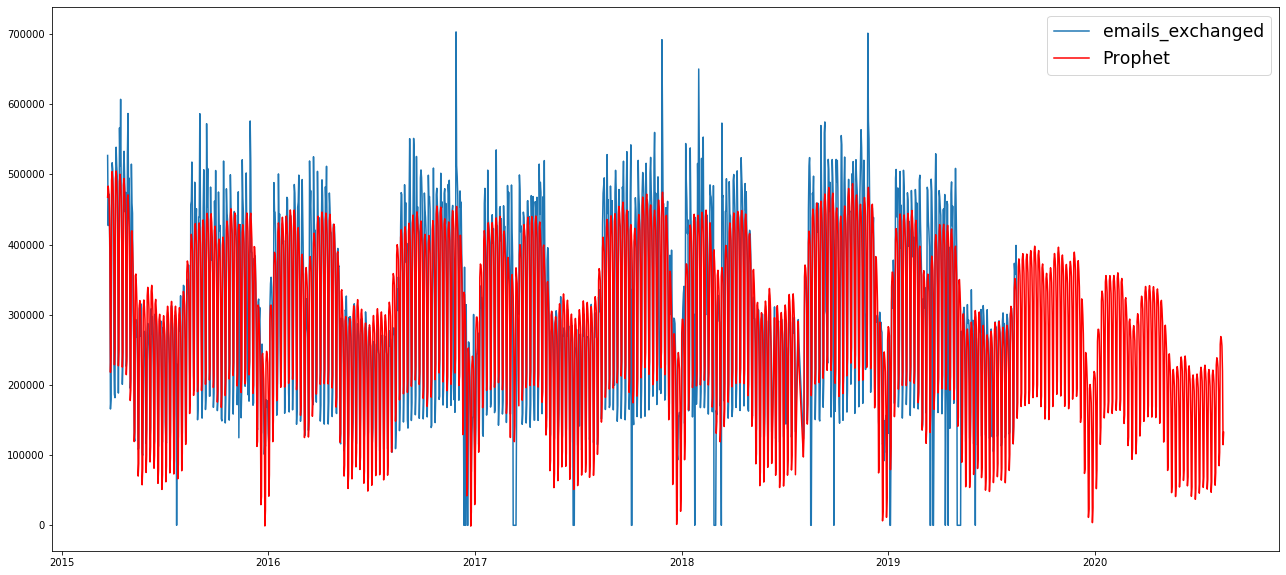

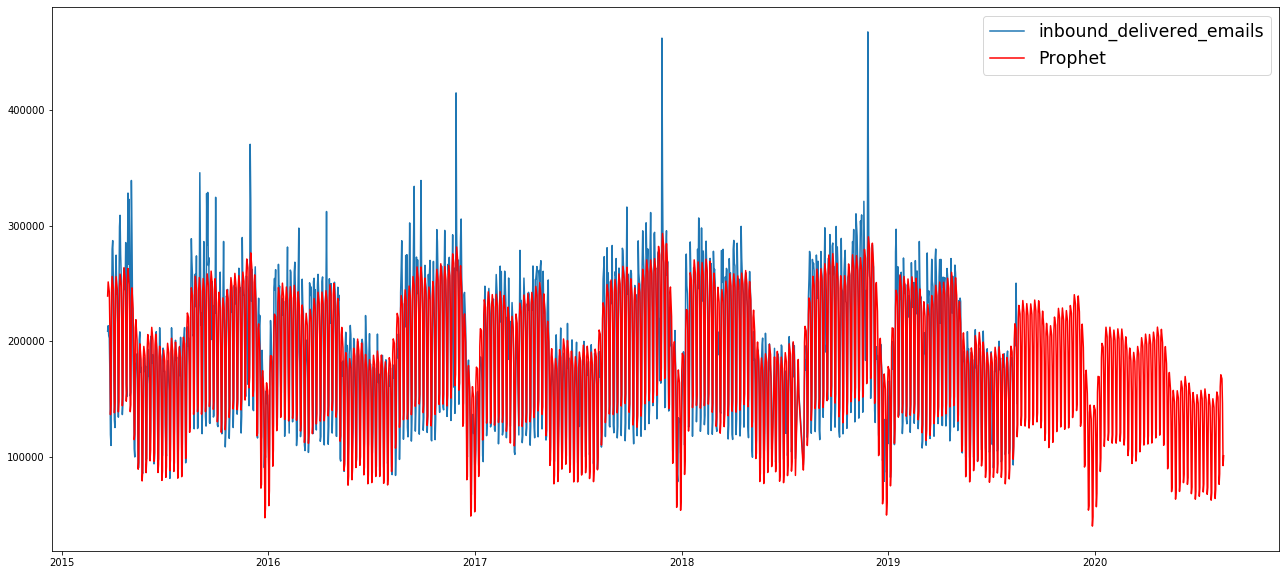

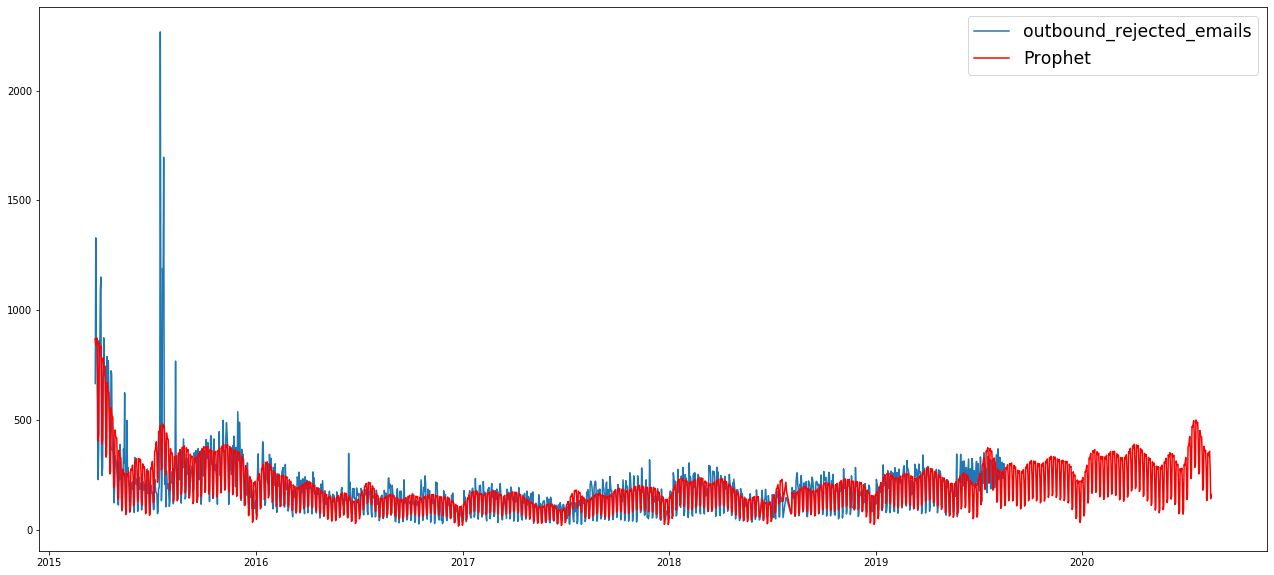

In [389]:
plot(other,other_prediction, True)

In [408]:
other = time_set(other)

In [411]:
five_att = time_set(five_att)

In [409]:
for x in range (len(other.columns)):
    n = other[[other.columns[x]]]
    n.to_csv(data_path_write2 + other.columns[x] + ".csv", index = True)

In [412]:
for x in range (len(five_att.columns)):
    n = five_att[[five_att.columns[x]]]
    n.to_csv(data_path_write2 + five_att.columns[x] + ".csv", index = True)

Removing 0s when there is an outage

In [356]:
five_att_0_removed = pick_your_poison(3)

The five attributes


In [148]:
five_att_0_removed = five_att_0_removed [five_att_0_removed ['emails_received'] != 0] 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for emails_received_time_prediction.csv
  horizon           mse          rmse           mae      mape  coverage
0 38 days  6.370809e+09  79817.347732  61605.774375  0.179890  0.571150
1 39 days  6.449424e+09  80308.304755  62486.939389  0.182379  0.564912
2 40 days  6.664521e+09  81636.519569  63834.009797  0.188216  0.555556
3 41 days  6.722694e+09  81992.035051  64263.241177  0.190504  0.550877
4 42 days  6.890087e+09  83006.548976  65047.927653  0.193814  0.556725
Performance tail for emails_received_time_prediction.csv
     horizon           mse           rmse           mae      mape  coverage
323 361 days  1.331961e+10  115410.617552  92699.590608  0.326479       1.0
324 362 days  1.351927e+10  116272.408213  93857.715457  0.326142       1.0
325 363 days  1.390942e+10  117938.189228  95919.063998  0.329520       1.0
326 364 days  1.421180e+10  119213.243038  97286.389345  0.331494       1.0
327 365 days  1.458382e+10  120763.487907  98594.307515  0.333097       1.

INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for emails_sent_time_prediction.csv
  horizon           mse         rmse          mae      mape  coverage
0 38 days  6.109340e+07  7816.226496  6327.784723  0.238228  0.643275
1 39 days  6.219218e+07  7886.201800  6417.261798  0.240283  0.636257
2 40 days  6.541226e+07  8087.784433  6548.967286  0.251297  0.635088
3 41 days  6.603256e+07  8126.042264  6607.588210  0.255525  0.629240
4 42 days  6.635469e+07  8145.838630  6628.795727  0.258523  0.629240
Performance tail for emails_sent_time_prediction.csv
     horizon           mse         rmse          mae      mape  coverage
323 361 days  4.987613e+07  7062.303336  4860.540628  0.238353  0.994152
324 362 days  4.964835e+07  7046.158554  4838.951440  0.234471  0.994152
325 363 days  5.186546e+07  7201.767867  4917.222778  0.232383  0.994152
326 364 days  5.263805e+07  7255.208818  4995.103275  0.233349  0.994152
327 365 days  5.427026e+07  7366.835442  5065.480995  0.236634  0.994152


INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for inbound_rejected_emails_time_prediction.csv
  horizon           mse          rmse          mae      mape  coverage
0 38 days  1.731919e+08  13160.241086  7469.005390  0.437257  0.853801
1 39 days  1.827179e+08  13517.319521  7658.380358  0.446750  0.852632
2 40 days  2.657631e+08  16302.241970  8384.957852  0.457321  0.846784
3 41 days  2.881543e+08  16975.107764  8758.346612  0.476875  0.839766
4 42 days  3.269728e+08  18082.389929  9270.045893  0.505390  0.830409
Performance tail for inbound_rejected_emails_time_prediction.csv
     horizon           mse          rmse           mae      mape  coverage
323 361 days  6.382615e+08  25263.836827  19657.908432  2.904431       1.0
324 362 days  6.432361e+08  25362.100037  19728.419075  2.928202       1.0
325 363 days  6.467718e+08  25431.708226  19797.919543  2.961817       1.0
326 364 days  6.354286e+08  25207.709543  19701.057091  2.981848       1.0
327 365 days  6.105117e+08  24708.535510  19458.730994  3.013633     

INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for inbound_spam_emails_time_prediction.csv
  horizon           mse          rmse          mae      mape  coverage
0 38 days  1.073421e+08  10360.603718  7962.753985  0.235547  0.734893
1 39 days  1.138685e+08  10670.918336  8196.739638  0.243638  0.725146
2 40 days  1.214660e+08  11021.162699  8504.440698  0.252277  0.713450
3 41 days  1.227217e+08  11077.984065  8587.122678  0.252979  0.711111
4 42 days  1.253049e+08  11193.965448  8684.914644  0.259155  0.711111
Performance tail for inbound_spam_emails_time_prediction.csv
     horizon           mse          rmse           mae      mape  coverage
323 361 days  8.772562e+08  29618.510951  21154.903165  0.872645       1.0
324 362 days  8.739953e+08  29563.412143  21152.610729  0.867839       1.0
325 363 days  8.629867e+08  29376.634909  21129.954791  0.871483       1.0
326 364 days  8.523887e+08  29195.696515  21055.219863  0.877058       1.0
327 365 days  8.611151e+08  29344.762897  21167.300347  0.884159       1.0


INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-08-27 00:00:00 and 2018-08-17 00:00:00


Performance head for inbound_non_spam_emails_time_prediction.csv
  horizon           mse          rmse           mae      mape  coverage
0 38 days  1.487958e+09  38574.052983  30499.716434  0.169482  0.617934
1 39 days  1.543590e+09  39288.553559  30875.506916  0.170486  0.612865
2 40 days  1.637310e+09  40463.689625  31754.773545  0.176596  0.600000
3 41 days  1.647752e+09  40592.507968  31867.461760  0.179637  0.597661
4 42 days  1.693504e+09  41152.209603  32450.642365  0.185621  0.588304
Performance tail for inbound_non_spam_emails_time_prediction.csv
     horizon           mse          rmse           mae      mape  coverage
323 361 days  5.686014e+09  75405.663197  65850.764744  0.428075  0.894737
324 362 days  5.747542e+09  75812.544735  66085.867081  0.425366  0.894737
325 363 days  5.930405e+09  77009.121904  66949.068712  0.424256  0.888889
326 364 days  6.059595e+09  77843.403589  67698.610144  0.425418  0.891228
327 365 days  6.094531e+09  78067.475812  68092.730423  0.42705

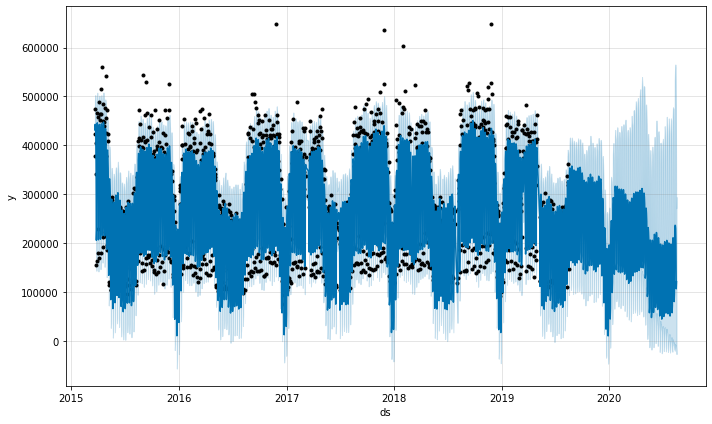

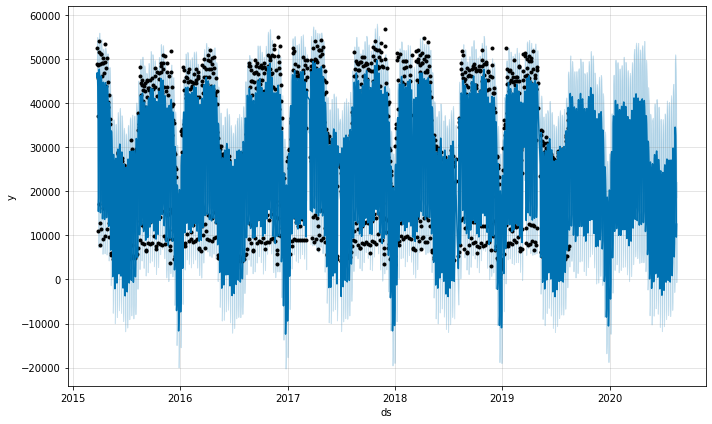

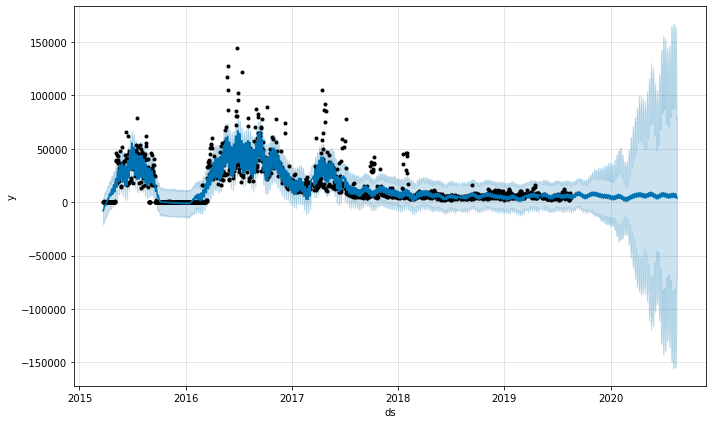

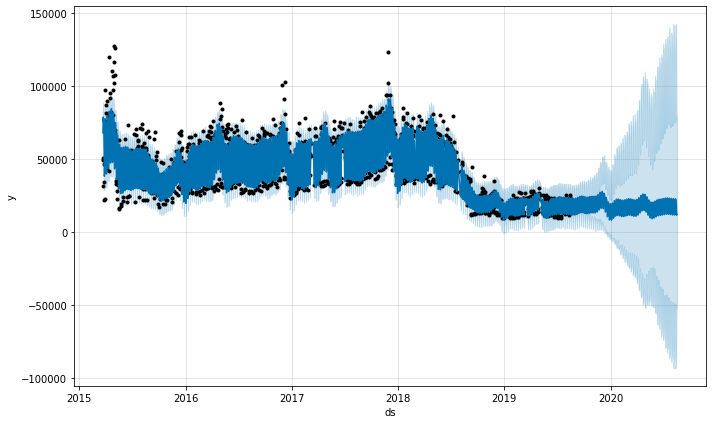

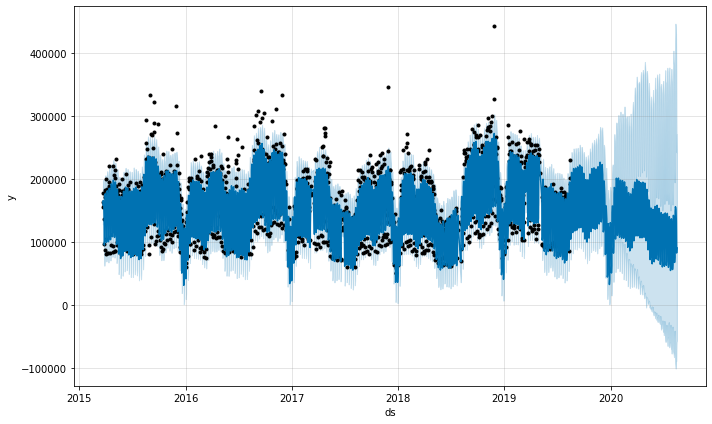

In [149]:
prediction1 = send_prediction(five_att_0_removed)

In [ ]:
plot